In [1]:
import numpy as np
import os 
import tifffile as tiff
import h5py
import multiprocessing as mp
import pandas as pd
from functools import partial
import matplotlib.pyplot as plt

In [2]:
# https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode
def rle2mask(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [
        np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])
    ]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = 1
    return img.reshape(shape).T

In [4]:
def create_and_save_csv(pd):
    pass

def create_mask(dset_name,pathc_coords):
    pass

def pad_image(image,mask,tile_x,tile_y):
    '''
    make image padded 
    '''
    new_shape = ((image.shape[0]//tile_x+1)*tile_x,
                 (image.shape[1]//tile_y+1)*tile_y,
                 image.shape[2])
    print('old shape is {}, new one is {}'.format(image.shape,new_shape))
    new_image = np.zeros(new_shape, dtype = image.dtype)
    new_mask = np.zeros((new_shape[0],new_shape[1]), dtype = mask.dtype)
    new_image[:image.shape[0], :image.shape[1], :] = image
    new_mask[:mask.shape[0], :mask.shape[1]] = mask
    return new_image, new_mask

def get_patch_coords(shape,tile_x,tile_y):
    '''
    get starting coordinates for every patch, store in a np array
    '''
    number_x_tiles = int(np.floor(shape[0]/tile_x))
    number_y_tiles = int(np.floor(shape[1]/tile_y))
    
    left = np.array([j*tile_x for j in range(number_x_tiles)])
    top = np.array([j*tile_y for j in range(number_y_tiles)])
    
    crop_start_point = np.array(np.meshgrid(left,top))
    crop_start_point = crop_start_point.T.reshape(-1, 2)
    
    return crop_start_point

def save_tile_image(patch_coords, image,  tile_x, tile_y,filename):
    '''
    save cropped image
    '''
    new_im = image[patch_coords[0]:patch_coords[0]+tile_x,
                   patch_coords[1]:patch_coords[1]+tile_y,:]
    tiff.imwrite(filename,data = new_im, dtype = new_im.dtype)
    
def save_tile_mask(mask, patch_coords, tile_x, tile_y, file, dset):
    '''
    save cropped mask
    '''
    new_mask = mask[patch_coords[0]:patch_coords[0]+tile_x,
                   patch_coords[1]:patch_coords[1]+tile_y]
    dset_name = dset
    file.create_dataset(dset_name, data = new_mask)




In [5]:
BASE_PATH = "../"
SAVE_PATH = "/run/media/alcauchy/Seagate Backup Plus Drive/kaggle/validation"
TRAIN_PATH = '../test'


In [7]:
df_train = pd.read_csv(
    os.path.join(BASE_PATH, "sample_submission.csv")
)

In [8]:
df_train

,id,predicted
0,b9a3865fc,NaN
1,b2dc8411c,NaN
2,26dc41664,NaN
3,c68fe75ea,NaN
4,afa5e8098,NaN


In [10]:
h5_file.close()

In [11]:
h5_file = h5py.File(os.path.join(SAVE_PATH,'mask.h5'),'w')
df_train = pd.read_csv(
    os.path.join(BASE_PATH, "sample_submission.csv")
)
tile_name_list = []
tile_size = 1024

for ind in df_train.index:
    imagename,rle = df_train.iloc[ind]
    image = tiff.imread(os.path.join(TRAIN_PATH,imagename+'.tiff'))
    
    if image.shape[0] == 3:
        image = np.transpose(image,(1,2,0))
    #mask = rle2mask(rle,(image.shape[1],image.shape[0]))
    mask = np.zeros((image.shape[0],image.shape[1]),dtype = image.dtype)
    img_new,msk_new = pad_image(image = image,
                                mask = mask,
                                tile_x = tile_size,
                                tile_y = tile_size)
    patch_coords = get_patch_coords(img_new.shape,
                                    tile_x=tile_size,
                                    tile_y=tile_size)

    for i,patch in enumerate(list(patch_coords)):
        tile_name = imagename+"_"+str(i)
        filename = os.path.join(SAVE_PATH,tile_name+'.tiff')

        save_tile_image(patch_coords  = patch, image = img_new,  
                        tile_x = tile_size, tile_y = tile_size,
                        filename = filename)

        save_tile_mask(msk_new, patch_coords = patch, 
                       tile_x = tile_size, tile_y = tile_size, 
                       file = h5_file, dset = tile_name)
        tile_name_list.append(tile_name)
h5_file.close()
df = pd.DataFrame( data = {'name': tile_name_list})
df.to_csv(os.path.join(SAVE_PATH,'names.csv'))

old shape is (31295, 40429, 3), new one is (31744, 40960, 3)
old shape is (14844, 31262, 3), new one is (15360, 31744, 3)
old shape is (38160, 42360, 3), new one is (38912, 43008, 3)
old shape is (26840, 49780, 3), new one is (27648, 50176, 3)
old shape is (36800, 43780, 3), new one is (36864, 44032, 3)


# TEST

e79de561c_234


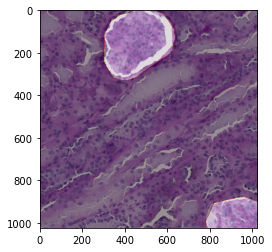

In [214]:
ind = 3912
test_name = df.iloc[ind]['name']
print(test_name)
img = tiff.imread(os.path.join(SAVE_PATH,test_name+'.tiff'))
h5_file = h5py.File(os.path.join(SAVE_PATH,'mask.h5'),'r')
mask = h5_file[test_name][()]
plt.imshow(img)
plt.imshow(mask,cmap = 'hot',alpha = 0.3)
plt.show()